# Welcome to your end-to-end machine learning project 
> Try it yourself !!

In [ ]:
!pip install shap # Install SHAP

In [ ]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sn
import matplotlib.pyplot as plt
# To show the plots in notebook.
%matplotlib inline

from sklearn import preprocessing,model_selection,metrics
from sklearn import ensemble

from imblearn import over_sampling
import shap

RANDOM_STATE = 1234

## Frame the problem

**Source**
> https://www.kaggle.com/rikdifos/credit-card-approval-prediction 

**Goal**
> To predict if a new application should be approved or not using the past history data of the company's credit-card customers.

**Features**
>Information in the application form.

**Target**
> `Good client` if they cleared their credit card outstanding balance witin 60 days after the latest due, otherwise `Bad client`.

*Surely there should be other better definitions to label good and bad clients.* 

## Select performance measures

> F1, ROC curve + AUC, Precision-Recall curve + AUC

## Get the data

In [ ]:
from google.colab import files # Colab library to upload files to notebook

# Install kaggle package so that we can use the kaggle api e.g. for downloading data.  
!pip install kaggle

# Upload kaggle API key file
uploaded = files.upload()

!mkdir '/root/.kaggle'
!cp 'kaggle.json' '/root/.kaggle/.'
!chmod 600 '/root/.kaggle/kaggle.json'

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets list -s credit

ref                                                          title                                                 size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
sakshigoyal7/credit-card-customers                           Credit Card customers                                379KB  2020-11-19 07:38:44          40000  
mlg-ulb/creditcardfraud                                      Credit Card Fraud Detection                           66MB  2018-03-23 01:17:27         335123  
uciml/german-credit                                          German Credit Risk                                    11KB  2016-12-14 21:25:02          25543  
rikdifos/credit-card-approval-prediction                     Credit Card Approval Prediction                        5MB  2020-03-24 10:04:48          15239  
upadorprofzs/credit-risk                            

In [ ]:
!kaggle datasets download -d rikdifos/credit-card-approval-prediction # Download the data from the competition.

 94% 5.00M/5.32M [00:00<00:00, 35.6MB/s]
100% 5.32M/5.32M [00:00<00:00, 33.9MB/s]


In [ ]:
!unzip "/content/credit-card-approval-prediction.zip" -d "/content/credit-card-approval-prediction"

Archive:  /content/credit-card-approval-prediction.zip
  inflating: /content/credit-card-approval-prediction/application_record.csv  
  inflating: /content/credit-card-approval-prediction/credit_record.csv  


In [ ]:
df_app_rec = pd.read_csv('/content/credit-card-approval-prediction/application_record.csv') 
df_credit_rec = pd.read_csv('/content/credit-card-approval-prediction/credit_record.csv') # Time-series data

### Creating labels

In [ ]:
'''
MONTHS_BALANCE
The month of the extracted data is the starting point, backwards, 
0 is the current month, -1 is the previous month, and so on

STATUS
0: 1-29 days past due 
1: 30-59 days past due 
2: 60-89 days overdue 
3: 90-119 days overdue 
4: 120-149 days overdue 
5: Overdue or bad debts, write-offs for more than 150 days 
C: paid off that month 
X: No loan for the month
'''

df_credit_rec[:20]

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [ ]:
df_credit_rec['Target'] = df_credit_rec['STATUS'].isin(['X','C','0'])
df_credit_rec_uniqueID = df_credit_rec.sort_values(['ID','MONTHS_BALANCE']).drop_duplicates(subset='ID',keep='last')

In [ ]:
df_credit_rec[df_credit_rec['ID'] == 5150482]

,ID,MONTHS_BALANCE,STATUS,Target
1048494,5150482,-11,C,True
1048495,5150482,-12,C,True
1048496,5150482,-13,C,True
1048497,5150482,-14,C,True
1048498,5150482,-15,C,True
1048499,5150482,-16,C,True
1048500,5150482,-17,0,True
1048501,5150482,-18,0,True
1048502,5150482,-19,0,True
1048503,5150482,-20,0,True


In [ ]:
# Merge the application records and the defined targets.
df_data = pd.merge(df_app_rec,df_credit_rec_uniqueID,how='inner',on='ID').drop(
    ['ID','MONTHS_BALANCE','STATUS'],axis=1)

In [ ]:
df_data['Target'].value_counts()

True     36075
False      382
Name: Target, dtype: int64

In [ ]:
df_data['Target'] = 1-df_data['Target']*1

In [ ]:
df_data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Target
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,1
36453,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36454,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36455,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,1


### Clean the data

In [ ]:
# Todo: Check duplicated IDs, etc.scห

## Split the data

In [ ]:
train,test = model_selection.train_test_split(df_data,
                      test_size=0.2,
                      random_state=RANDOM_STATE,shuffle=True,
                      stratify=df_data['Target'])

In [ ]:
train,test = train.reset_index(drop=True),test.reset_index(drop=True)

In [ ]:
X_train,y_train = train.iloc[:,:-1],train.iloc[:,-1]
X_test,y_test = test.iloc[:,:-1],test.iloc[:,-1]

In [ ]:
y_train.sum()/len(y_train),y_test.sum()/len(y_test)

(0.010492028115892336, 0.010422380691168404)

## Understand and preprocess the data

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165 entries, 0 to 29164
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          29165 non-null  object 
 1   FLAG_OWN_CAR         29165 non-null  object 
 2   FLAG_OWN_REALTY      29165 non-null  object 
 3   CNT_CHILDREN         29165 non-null  int64  
 4   AMT_INCOME_TOTAL     29165 non-null  float64
 5   NAME_INCOME_TYPE     29165 non-null  object 
 6   NAME_EDUCATION_TYPE  29165 non-null  object 
 7   NAME_FAMILY_STATUS   29165 non-null  object 
 8   NAME_HOUSING_TYPE    29165 non-null  object 
 9   DAYS_BIRTH           29165 non-null  int64  
 10  DAYS_EMPLOYED        29165 non-null  int64  
 11  FLAG_MOBIL           29165 non-null  int64  
 12  FLAG_WORK_PHONE      29165 non-null  int64  
 13  FLAG_PHONE           29165 non-null  int64  
 14  FLAG_EMAIL           29165 non-null  int64  
 15  OCCUPATION_TYPE      20116 non-null 

In [ ]:
col_names_2drop = ['OCCUPATION_TYPE'] # Drop it due to missing
# Todo: Try other methods

In [ ]:
X_train.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,29165.000000,2.916500e+04,29165.000000,29165.000000,29165.0,29165.000000,29165.000000,29165.000000,29165.000000
mean,0.432745,1.866744e+05,-15976.598971,59542.030859,1.0,0.224104,0.294634,0.089525,2.201680
std,0.740998,1.019835e+05,4204.237563,137898.369167,0.0,0.416998,0.455886,0.285505,0.910885
min,0.000000,2.700000e+04,-25152.000000,-15661.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19435.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.575000e+05,-15570.000000,-1542.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12454.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,14.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000


In [ ]:
'''
Count backwards from current day(0). 
If positive, it means the person currently unemployed.
'''
X_train.loc[X_train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED'].unique()

array([365243])

In [ ]:
# Put 'DAYS_EMPLOYED' = 0 for unemployed people.
X_train = X_train.replace(to_replace={'DAYS_EMPLOYED':365243},value=0)
X_train.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,29165.000000,2.916500e+04,29165.000000,29165.000000,29165.0,29165.000000,29165.000000,29165.000000,29165.000000
mean,0.432745,1.866744e+05,-15976.598971,-2197.999657,1.0,0.224104,0.294634,0.089525,2.201680
std,0.740998,1.019835e+05,4204.237563,2369.951242,0.0,0.416998,0.455886,0.285505,0.910885
min,0.000000,2.700000e+04,-25152.000000,-15661.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19435.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.575000e+05,-15570.000000,-1542.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12454.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,14.000000,1.575000e+06,-7705.000000,0.000000,1.0,1.000000,1.000000,1.000000,15.000000


In [ ]:
# Todo: Explore each single feature if there is any suspected values. If so, do something.
''' 
Recommended tool:
   https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/index.html
'''

' \nRecommended tool:\n   https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/index.html\n'

In [ ]:
# One-hot encoding
cat_features = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
                'NAME_INCOME_TYPE','NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE','NAME_EDUCATION_TYPE']
onthot_enc = preprocessing.OneHotEncoder()
onthot_enc.fit(X_train[cat_features])

X_encoded = onthot_enc.transform(X_train[cat_features]).toarray()
print(X_encoded.shape)
cat_col_names = []
for i in range(len(cat_features)):
  cat_col_names = cat_col_names + [cat_features[i]+'_'+cat_enc for cat_enc in onthot_enc.categories_[i]]
df_train_cat_encoded = pd.DataFrame(X_encoded,columns=cat_col_names)
print(df_train_cat_encoded.shape)

(29165, 27)
(29165, 27)


In [ ]:
# Todo: Ordinal encoding for NAME_EDUCATION_TYPE' instead
X_train['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [ ]:
# DAYS_BIRTH >> age_year
def days_birth_to_year(X):
  X.loc[:,'DAYS_BIRTH'] = (X['DAYS_BIRTH']*-1/365).astype(int)

In [ ]:
# Todo: DAYS_EMPLOYED >> ??

In [ ]:
# Prepapre the final feature matrix
col_names_2drop += cat_features
X_train = pd.concat([X_train,df_train_cat_encoded],axis=1).drop(col_names_2drop,axis=1)
print(X_train.shape)

(29165, 36)


In [ ]:
# Todo: Make the code more modular.

In [ ]:
X_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,0,1350000.0,-12999,-1560,1,0,1,1,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,270000.0,-11451,-2206,1,0,1,0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,135000.0,-15842,-1419,1,0,0,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,225000.0,-13021,-5082,1,1,0,0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,135000.0,-9167,-947,1,0,0,0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29160,0,180000.0,-12461,-678,1,0,0,0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29161,0,126000.0,-23751,0,1,0,0,0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29162,0,292500.0,-12554,-5326,1,0,0,1,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29163,0,157500.0,-19843,-1922,1,0,0,0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train, evaluate, fine-tune the models
> This is your model selection step

In [ ]:
# OK
model_selection.cross_val_score(ensemble.RandomForestClassifier(),X_train,y_train,cv=5,scoring='f1')

array([0.15384615, 0.1686747 , 0.17073171, 0.1038961 , 0.09090909])

In [ ]:
# !!!!! Wrong because there is information leak from the training set to the validation set !!!!!
oversampler = over_sampling.SMOTE()
X_train_oversampled,y_train_oversampled = oversampler.fit_resample(X_train,y_train)
model_selection.cross_val_score(ensemble.RandomForestClassifier(),X_train_oversampled,y_train_oversampled,cv=5,scoring='f1')

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


array([0.97804039, 0.99749287, 0.99757827, 0.99688904, 0.99654398])

In [ ]:
def smote(X,y):
  oversampler = over_sampling.SMOTE()
  X_balanced,y_balanced = oversampler.fit_resample(X,y)
  return X_balanced,y_balanced 

In [ ]:
# Todo: Try other data-balancing methods

In [ ]:
def run_model(model,resampler=None,preprocessors=[]):
  # Return values
  f1_train_list,f1_val_list = [],[]
  y_train_val_list,y_train_val_pred_list = [],[]

  # Stratified cross-validation
  kf = model_selection.KFold(n_splits=5,shuffle=True,random_state=RANDOM_STATE)
  for train_index, val_index in kf.split(X_train):
    # Split the data
    X_train_train, X_train_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_train, y_train_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Feature engineering
    for preprocessor in preprocessors:
      preprocessor(X_train_train)
      preprocessor(X_train_val)

    # Balance the data
    if resampler is not None:
      X_train_train,y_train_train = resampler(X_train_train,y_train_train)

    # Train the model
    model.fit(X_train_train,y_train_train)

    # Evaluate on the training set
    y_train_train_pred = model.predict(X_train_train)
    f1 = metrics.f1_score(y_train_train,y_train_train_pred)
    f1_train_list.append(f1)

    # Evaluate on the validation set
    y_train_val_pred = model.predict(X_train_val)
    f1 = metrics.f1_score(y_train_val,y_train_val_pred)
    f1_val_list.append(f1)

    y_train_val_list += list(y_train_val)
    y_train_val_pred_list += list(model.predict_proba(X_train_val)[:,1])

  return f1_train_list,f1_val_list,y_train_val_list,y_train_val_pred_list

In [ ]:
f1_train,f1_val = {},{}
y_train_val,y_train_val_pred = {},{}

In [ ]:
model_name = 'rf'
f1_train[model_name],f1_val[model_name],y_train_val[model_name],y_train_val_pred[model_name] = run_model(
    ensemble.RandomForestClassifier(),resampler=None,preprocessors = [days_birth_to_year])

In [ ]:
model_name = 'rf_smote'
f1_train[model_name],f1_val[model_name],y_train_val[model_name],y_train_val_pred[model_name] = run_model(
    ensemble.RandomForestClassifier(),resampler=smote,preprocessors = [days_birth_to_year])

In [ ]:
# Todo: Try other models.

In [ ]:
# Todo: Fine-tune hyper-parameters. You need to implement your own grid / randomized search, due to the resampling scheme.

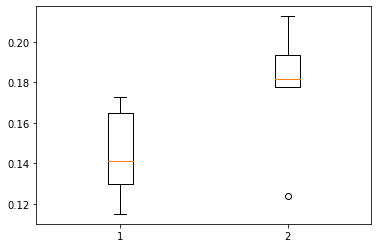

In [ ]:
# Model comparison
bp = plt.boxplot([f1_val['rf'],f1_val['rf_smote']])

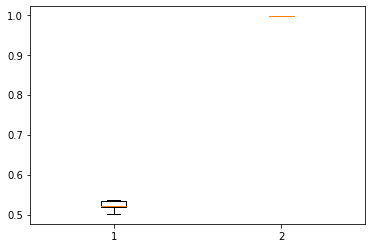

In [ ]:
# Check if the model is overfitting or underfitting
bp = plt.boxplot([f1_train['rf'],f1_train['rf_smote']])

## Evaluate more and interpret the results

In [ ]:
def plot_confusion_matrix(model_name,norm=True):
  confusion_matrix = metrics.confusion_matrix(y_train_val[model_name],np.array(y_train_val_pred[model_name])>0.5)
  fmt = 'd'
  if norm:
    confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fmt = '.4f'

  ax = sn.heatmap(confusion_matrix, cmap="Blues", annot=True,fmt=fmt)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

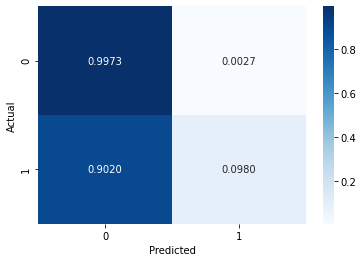

In [ ]:
plot_confusion_matrix(model_name='rf',norm=True)

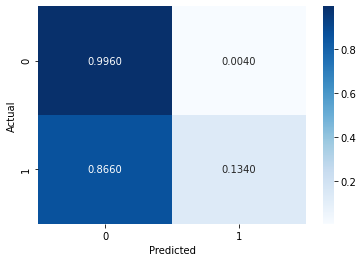

In [ ]:
plot_confusion_matrix(model_name='rf_smote',norm=True)

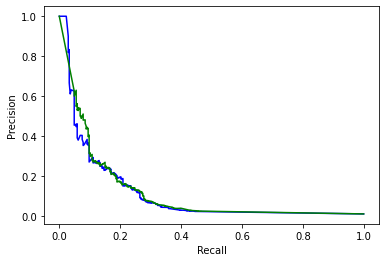

In [ ]:
# Precision-recall curve
for model_name,color in zip(['rf','rf_smote'],['b','g']):
  precisions, recalls, thresholds = metrics.precision_recall_curve(y_train_val[model_name],y_train_val_pred[model_name])
  plt.plot(recalls,precisions,color=color)
  plt.xlabel('Recall')
  plt.ylabel('Precision')

In [ ]:
# Todo: Analyze your model candidates with shap values; you might find something useful. https://www.kaggle.com/dansbecker/shap-values

## Evaluate your best model on the test set.

In [ ]:
# Todo: What is your best model? Try it on the test set and this is the unbiased generalization performance of your model.

## Launch and maintain your system

In [ ]:
# Retrain your final model using all dataset.